In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"
import theano

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_ivir1bg4.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


In [2]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
# just here as it is subfolder in experimental
os.pardir = '../..'

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

# new for this
import importlib
from gempy.assets import kriging

In [3]:
path_to_data = os.pardir+"/data/input_data/jan_models/"
f=3
geo_data = gp.create_data([0,2500,0,int(40),0,1100],resolution=[int(125*f),4,int(55*f)], 
                        path_o = path_to_data + "model7b_orientations_fault.csv",
                        path_i = path_to_data + "model7b_surface_points_fault.csv") 

Active grids: ['regular']


In [4]:
#geo_data.get_data('kriging')
#geo_data.additional_data.kriging_data.modify_kriging_parameters('nugget grad', 0)
#geo_data.additional_data.kriging_data.modify_kriging_parameters('nugget scalar', 0)
#gp.update_additional_data

In [5]:
#geo_data.get_data('kriging')

In [6]:
geo_data.get_data('kriging')

,values
range,2731.59
$C_o$,177657
drift equations,"[3, 0]"
nugget grad,0.01
nugget scalar,1e-06


In [7]:
gp.map_series_to_surfaces(geo_data, {"Fault_Series": ('fault'), "Strat_Series1": ('rock3'),
                                     "Strat_Series2": ('rock2','rock1'),
                                     "Basement_Series":('basement')})

geo_data.set_is_fault(['Fault_Series'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault_Series,True,False
Strat_Series1,False,False
Strat_Series2,False,False
Basement_Series,False,False


In [8]:
#geo_data.surfaces.colors.change_colors({'fault': '#000000', 'rock1': '#CC081F', 'rock2': '#FFAA00',
#                                        'rock3': '#006C8C', 'basement': '#097703'})

geo_data.surfaces.colors.change_colors({'fault': '#000000', 'rock1': '#E1E1E1', 'rock2': '#B1B1B1',
                                        'rock3': '#4B4B4B', 'basement': '#7B7B7B'})

,surface,series,order_surfaces,isBasement,color,id
3,fault,Fault_Series,1,False,#000000,1
0,rock3,Strat_Series1,1,False,#4B4B4B,2
1,rock2,Strat_Series2,1,False,#B1B1B1,3
2,rock1,Strat_Series2,2,False,#E1E1E1,4
4,basement,Basement_Series,1,True,#7B7B7B,5


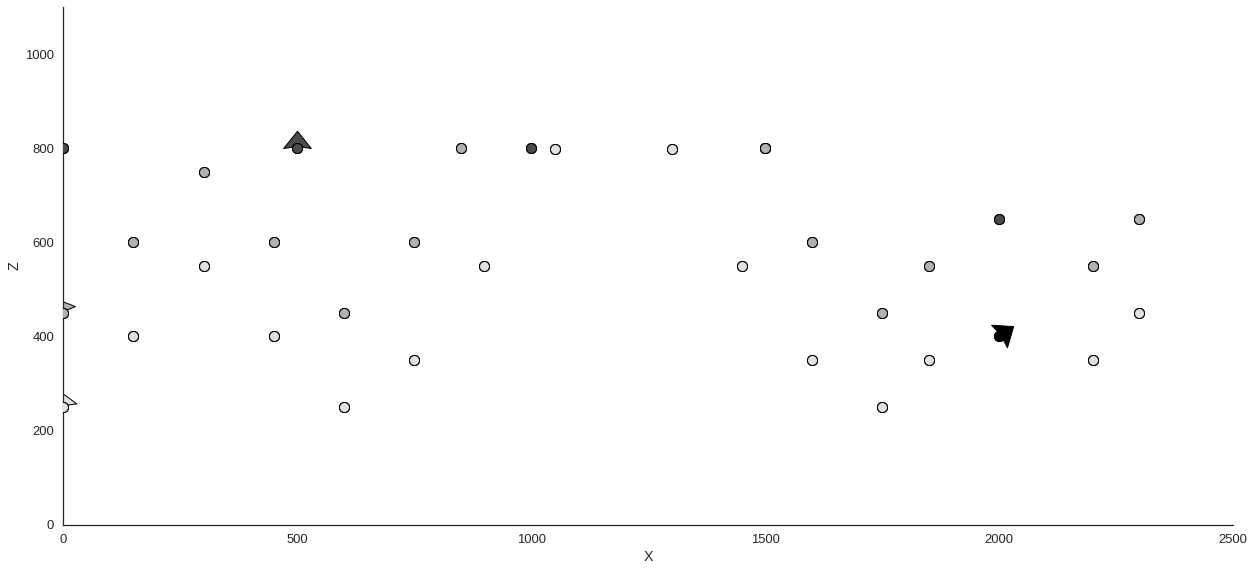

In [9]:
%matplotlib inline
gp.plot.plot_data(geo_data, direction='y')

In [10]:
gp.set_interpolation_data(geo_data,
                          output='geology', compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[],
                         dtype='float64')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float64
Number of faults:  1
Compilation Done!


In [11]:
sol=gp.compute_model(geo_data, compute_mesh=True)

In [12]:
#geo_data.add_topography(source='random')

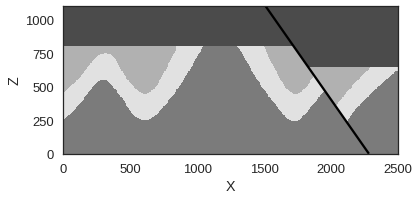

In [13]:
%matplotlib inline
gp.plot.plot_section(geo_data, cell_number=1,
                         direction='y', show_data=True)

# Kriging test

In [14]:
# conditioning data (data measured at locations)
cond_data = np.array([[100,.5,500,20],[900,.5,500,20],[500,.5,550,20],[300,.5,400,20]])

domain = kriging.domain(model=sol, domain=[4], data=cond_data)

variogram_model = kriging.variogram_model(theoretical_model = 'exponential', 
                                          range_=300, sill=10, nugget=0.1)

In [15]:
solution = kriging.create_kriged_field(domain, variogram_model)

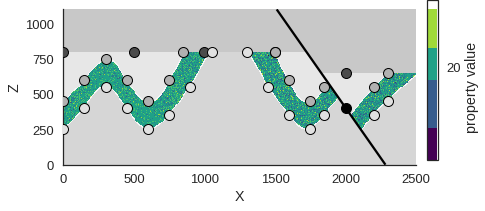

In [16]:
solution.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=0.7,
                          show_data=False, legend=True)

# SGS non-eucl?

In [17]:
importlib.reload(kriging)

<module 'gempy.assets.kriging' from '../../../gempy/assets/kriging.py'>

In [18]:
domain = kriging.domain(model=sol, domain=[4], data=cond_data, fault=True)

In [19]:
np.random.seed(10340)
# Manual way to input sgs stuff with scalar field values for non euclidian distance 
# nit nice but good enough for figure

geo_data.set_custom_grid(domain.data[:,:3])
gp.compute_model(geo_data, compute_mesh=False)

locs = np.hstack((domain.krig_grid, domain.krig_scal.reshape((len(domain.krig_grid),1)),domain.fault_model.reshape((len(domain.krig_grid),1))))
np.random.shuffle(locs)

sgs_locations = np.vstack((domain.data[:,:3], locs[:,:3]))
sgs_gradients = np.vstack((geo_data.solutions.custom[1][2].reshape((4,1)), locs[:,3].reshape((len(domain.krig_grid),1))))
sgs_fault_block = np.vstack((np.round(geo_data.solutions.custom[1][0].reshape((4,1))), locs[:,4].reshape((len(domain.krig_grid),1))))

sgs_grid = np.hstack((sgs_locations, sgs_gradients))
sol.grid.set_inactive('custom')

Active grids: ['regular' 'custom']


array([ True, False, False, False, False])

In [32]:
distance_type='euclidian'

In [33]:
solution_sim = kriging.create_gaussian_field(domain, variogram_model, distance_type=distance_type, 
                                             moving_neighbourhood='n_closest', sgs_grid=sgs_grid, shuffled_grid=locs,
                                            sgs_fault_block=sgs_fault_block)

In [34]:
#solution_sim.plot_results(geo_data=geo_data, prop='val', contour=True, direction='y', cell_number=1, alpha=0.9,
                          #show_data=False, legend=True)

#plt.savefig('test_figure5.svg')

In [35]:
sgs_locations[16]

array([4.36666667e+02, 5.33333333e-02, 5.23242276e+02])

In [36]:
sgs_locations[:,2]

array([500.        , 500.        , 550.        , ..., 416.21138211,
       376.07479675, 402.83252033])

In [37]:
np.where(sgs_locations[:,0]==810)

(array([  121,   564,   775,  1017,  1056,  1364,  1922,  2286,  2408,
         2847,  3164,  3430,  3780,  4281,  4516,  4620,  4734,  4763,
         4825,  5114,  5848,  6184,  6486,  6503,  6534,  6983,  7034,
         7657,  7934,  8208,  8236,  8890,  9367,  9526, 10001, 10078,
        10083, 10442, 10544, 10563, 10612, 10626, 11031, 11188, 11492,
        11686, 11697, 11987, 12331, 12372, 12401, 12493, 12576, 12606,
        12707, 13291, 13506, 13883, 13912, 14072, 14317, 14445, 14510,
        15041, 15212, 15278, 15326, 15526, 15594, 15711, 15727, 15823,
        16433, 17047, 17116, 17296, 17386, 17395, 17762, 17785, 17980,
        18050, 18100, 18232, 18381, 18530, 18548, 18913, 19361, 19618,
        19632, 19664, 19822, 20079, 20152, 20265, 20336, 20476, 20940,
        21216, 22307, 22331, 22655, 22726, 23010, 23481, 23691, 23849,
        23860, 24086, 24093, 24359, 24544, 24687, 24773, 25165, 25365,
        25766, 25780, 26051, 26149, 26172, 26215, 26696, 26797, 27254,
      

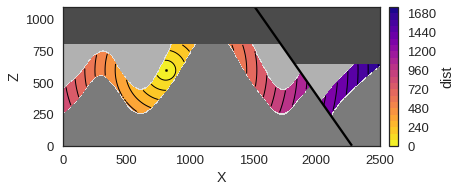

In [38]:
point=560

solution_sim.plot_distances(geo_data=geo_data, direction='y', cell_number=1, point=point,
                            contour=True, alpha=0.5,  interpolation='nearest', legend=True)

plt.scatter(sgs_locations[point+4][0], sgs_locations[point+4][2], color='black', s=5)

plt.savefig(distance_type+'figure.svg')